## The directories for various files is created using the following code

#### Here, the model that is used is a pretrained model fetched from tensorflow2 model zoo which has many kinds of object detection models. Out of various types of models, ssd mobilenet v2 fpn lite 320x320 is chosen by taking into account its speed (22ms) and accuracy (22.2 mAP). 

In [2]:
import os

In [3]:
CUSTOM_MODEL_NAME = 'my_ssd_mobnet' 
PRETRAINED_MODEL_NAME = 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8'
PRETRAINED_MODEL_URL = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz'
TF_RECORD_SCRIPT_NAME = 'generate_tfrecord.py'
LABEL_MAP_NAME = 'label_map.pbtxt'

In [4]:
paths = {
    'WORKSPACE_PATH': os.path.join('Tensorflow', 'workspace'),
    'SCRIPTS_PATH': os.path.join('Tensorflow','scripts'),
    'APIMODEL_PATH': os.path.join('Tensorflow','models'),
    'ANNOTATION_PATH': os.path.join('Tensorflow', 'workspace','annotations'),
    'IMAGE_PATH': os.path.join('Tensorflow', 'workspace','images'),
    'MODEL_PATH': os.path.join('Tensorflow', 'workspace','models'),
    'PRETRAINED_MODEL_PATH': os.path.join('Tensorflow', 'workspace','pre-trained-models'),
    'CHECKPOINT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME), 
    'OUTPUT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'export'), 
    'TFJS_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfjsexport'), 
    'TFLITE_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfliteexport'), 
    'PROTOC_PATH':os.path.join('Tensorflow','protoc')
 }

In [5]:
files = {
    'PIPELINE_CONFIG':os.path.join('Tensorflow', 'workspace','models', CUSTOM_MODEL_NAME, 'pipeline.config'),
    'TF_RECORD_SCRIPT': os.path.join(paths['SCRIPTS_PATH'], TF_RECORD_SCRIPT_NAME), 
    'LABELMAP': os.path.join(paths['ANNOTATION_PATH'], LABEL_MAP_NAME)
}

In [ ]:
for path in paths.values():
    if not os.path.exists(path):
        !mkdir -p {path}

#### we are cloning the tensorflow repo consisting of all the models

In [ ]:
if not os.path.exists(os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection')):
    !git clone https://github.com/tensorflow/models {paths['APIMODEL_PATH']}

#### Now by running the following command, tensorflow's object detection model will be installed

In [1]:
!cd Tensorflow/models/research && protoc object_detection/protos/*.proto --python_out=. && cp object_detection/packages/tf2/setup.py . && python3 -m pip install -I --user .

Processing /Users/sharath/Desktop/TFODCourse/Tensorflow/models/research
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Using cached avro-python3-1.10.2.tar.gz (38 kB)
  Using cached apache_beam-2.32.0-py3-none-any.whl
  Using cached Pillow-8.3.1-cp39-cp39-macosx_10_10_x86_64.whl (2.9 MB)
  Using cached lxml-4.6.3-cp39-cp39-macosx_10_9_x86_64.whl (4.6 MB)
  Using cached matplotlib-3.4.3-cp39-cp39-macosx_10_9_x86_64.whl (7.2 MB)
  Using cached Cython-0.29.24-cp39-cp39-macosx_10_9_x86_64.whl (1.9 MB)
  Using cached contextlib2-21.6.0-py2.py3-none-any.whl (13 kB)
^C
ERROR: Operation cancelled by user
You should consider upgrading via the '/Libra

#### Now that object detection model can be imported

In [6]:
import object_detection

#### saving the pretrained model in the allocated folder

In [ ]:
!wget {PRETRAINED_MODEL_URL}
!mv {PRETRAINED_MODEL_NAME+'.tar.gz'} {paths['PRETRAINED_MODEL_PATH']}
!cd {paths['PRETRAINED_MODEL_PATH']} && tar -zxvf {PRETRAINED_MODEL_NAME+'.tar.gz'}

#### This segment creates a label map

In [ ]:
labels = [{'name':'licence', 'id':1}]
with open(files['LABELMAP'], 'w') as f:
    for label in labels:
        f.write('item { \n')
        f.write('\tname:\'{}\'\n'.format(label['name']))
        f.write('\tid:{}\n'.format(label['id']))
        f.write('}\n')

#### The following commands converts the test and train data into the tensorflow record format that could be used in the model

In [ ]:
!git clone https://github.com/nicknochnack/GenerateTFRecord {paths['SCRIPTS_PATH']}

In [ ]:
!python3 {files['TF_RECORD_SCRIPT']} -x {os.path.join(paths['IMAGE_PATH'], 'train')} -l {files['LABELMAP']} -o {os.path.join(paths['ANNOTATION_PATH'], 'train.record')} 
!python3 {files['TF_RECORD_SCRIPT']} -x {os.path.join(paths['IMAGE_PATH'], 'test')} -l {files['LABELMAP']} -o {os.path.join(paths['ANNOTATION_PATH'], 'test.record')} 

#### By running the following command, we get a pipeline config file which contains the configurations for the model that could be finetuned as per our needs

In [ ]:
!cp {os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'pipeline.config')} {os.path.join(paths['CHECKPOINT_PATH'])}

#### In this section, the following code finetunes the pipeline.config file according to our specifications

In [ ]:
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format

In [ ]:
config = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])

In [ ]:
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "r") as f:                                                                                                                                                                                                                     
    proto_str = f.read()                                                                                                                                                                                                                                          
    text_format.Merge(proto_str, pipeline_config)  

In [ ]:
pipeline_config.model.ssd.num_classes = len(labels)
pipeline_config.train_config.batch_size = 4
pipeline_config.train_config.fine_tune_checkpoint = os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'checkpoint', 'ckpt-0')
pipeline_config.train_config.fine_tune_checkpoint_type = "detection"
pipeline_config.train_input_reader.label_map_path= files['LABELMAP']
pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'train.record')]
pipeline_config.eval_input_reader[0].label_map_path = files['LABELMAP']
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'test.record')]

In [ ]:
config_text = text_format.MessageToString(pipeline_config)                                                                                                                                                                                                        
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "wb") as f:                                                                                                                                                                                                                     
    f.write(config_text)   

#### So now we generate the command to train the model

In [5]:
TRAINING_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'model_main_tf2.py')

NameError: name 'paths' is not defined

In [3]:
command = "python {} --model_dir={} --pipeline_config_path={} --num_train_steps=2000".format(TRAINING_SCRIPT, paths['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'])

NameError: name 'TRAINING_SCRIPT' is not defined

In [ ]:
print(command)

#### we will get the command as 'python Tensorflow/models/research/object_detection/model_main_tf2.py --model_dir=Tensorflow/workspace/models/my_ssd_mobnet --pipeline_config_path=Tensorflow/workspace/models/my_ssd_mobnet/pipeline.config --num_train_steps=2000'.

#### Here the portion 'python Tensorflow/models/research/object_detection/model_main_tf2.py' specifies the model that we will be using, '--model_dir=Tensorflow/workspace/models/my_ssd_mobnet' specifies where our trained model should be saved, '--pipeline_config_path=Tensorflow/workspace/models/my_ssd_mobnet/pipeline.config' specifies the config file and '--num_train_steps=2000' specifies the number of steps , similar to epochs

#### Loading the model

In [7]:
import os
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util

In [8]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(paths['CHECKPOINT_PATH'], 'ckpt-3')).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

2021-09-13 11:42:55.134511: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Now by giving an image of a car as the input (given in the IMAGE_PATH variable) , an output with a bounding box over the licence plate can be obtained

In [9]:
import cv2 
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [10]:
category_index = label_map_util.create_category_index_from_labelmap(files['LABELMAP'])

In [50]:
IMAGE_PATH = os.path.join(paths['IMAGE_PATH'], 'test', 'licence.2539fdd6-0b2e-11ec-9b7c-acde48001122.jpg')

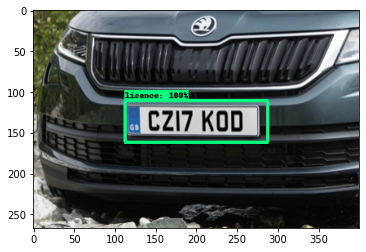

In [51]:
img = cv2.imread(IMAGE_PATH)
image_np = np.array(img)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=5,
            min_score_thresh=.8,
            agnostic_mode=False)

plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()

### Character identification and OCR

In [52]:
detection_threshold = 0.9

In [53]:
image = image_np_with_detections
scores = list(filter(lambda x : x > detection_threshold,detections['detection_scores']))
boxes = detections['detection_boxes'][:len(scores)]
classes = detections['detection_classes'][:len(scores)]

In [54]:
width = image.shape[1]
height = image.shape[0]

In [63]:
import imutils
import matplotlib.gridspec as gridspec

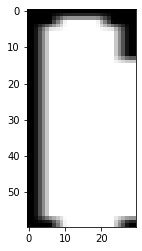

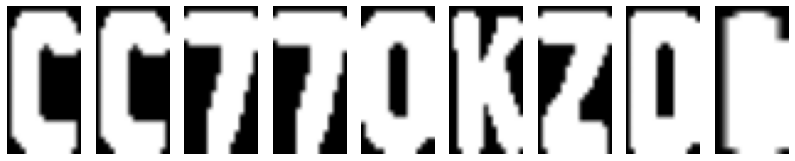

In [68]:
for idx,box in enumerate(boxes):
    roi = box*[height,width,height,width]
    region = image[int(roi[0]):int(roi[2]),int(roi[1]):int(roi[3])]
plate_image = cv2.convertScaleAbs(region, alpha=(100.0))
    
# convert to grayscale and blur the image

gray = cv2.cvtColor(plate_image, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray,(7,7),0)
    
# Applied inversed thresh_binary 
binary = cv2.threshold(blur, 180, 255,
                         cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
## Applied dilation 
kernel3 = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
thre_mor = cv2.morphologyEx(binary, cv2.MORPH_DILATE, kernel3)
thre_mor = cv2.cvtColor(thre_mor, cv2.COLOR_BGR2RGB)

edges = cv2.Canny(thre_mor,20,200)

contours = cv2.findContours(edges.copy(),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(contours)
contours = sorted(contours,key=cv2.contourArea, reverse = True)
test_roi = region.copy()

digit_w, digit_h = 30, 60

crop_characters=[]
for c in contours:
    (x,y,w,h) = cv2.boundingRect(c)
    ratio = h/w
    if 1<=ratio<=9.5: # Only select contour with defined ratio
        if h/plate_image.shape[0]>=0.5: # Select contour which has the height larger than 50% of the plate
            # Draw bounding box arroung digit number
            cv2.rectangle(test_roi, (x, y), (x + w, y + h), (0, 255,0), 2)
            curr_num = thre_mor[y:y+h,x:x+w]
            curr_num = cv2.resize(curr_num, dsize=(digit_w, digit_h))
            #_, curr_num = cv2.threshold(curr_num, 220, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            crop_characters.append(curr_num)

fig = plt.figure(figsize=(14,4))
grid = gridspec.GridSpec(ncols=len(crop_characters),nrows=1,figure=fig)

for i in range(len(crop_characters)):
    fig.add_subplot(grid[i])
    plt.axis(False)
    plt.imshow(crop_characters[i],cmap="gray")

In [70]:
import numpy as np
import imageio 
from keras.models import load_model

charac = []

for letters in crop_characters:
    ip = letters
    #bandw = np.dot(ip[...,:3],[0.2989, 0.5870, 0.1140])
    #ip = (ip.reshape(1,28,28,1))/255

    model = load_model('ocr.h5')

    output = model.predict(ip)
    charac.append(output)
print(charac)

ValueError: in user code:

    /Users/sharath/Library/Python/3.9/lib/python/site-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /Users/sharath/Library/Python/3.9/lib/python/site-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /Users/sharath/Library/Python/3.9/lib/python/site-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Users/sharath/Library/Python/3.9/lib/python/site-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Users/sharath/Library/Python/3.9/lib/python/site-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /Users/sharath/Library/Python/3.9/lib/python/site-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict_step(data)
    /Users/sharath/Library/Python/3.9/lib/python/site-packages/keras/engine/training.py:1537 predict_step
        return self(x, training=False)
    /Users/sharath/Library/Python/3.9/lib/python/site-packages/keras/engine/base_layer.py:1020 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /Users/sharath/Library/Python/3.9/lib/python/site-packages/keras/engine/input_spec.py:229 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer sequential is incompatible with the layer: : expected min_ndim=4, found ndim=3. Full shape received: (None, 30, 3)


In [199]:
import pytesseract 
def ocR (image):
    im = image
    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    threshold_img = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    customconfig = r'--oem 3 --psm 8'
    details = pytesseract.image_to_data(threshold_img, output_type=pytesseract.Output.DICT, config=customconfig, lang='eng')
    return threshold_img, details

['Mczi7', 'Koo', '|']


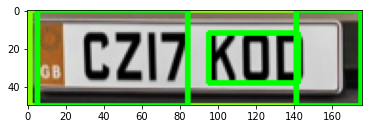

In [200]:
for idx,box in enumerate(boxes):
    roi = box*[height,width,height,width]
    region = image[int(roi[0]):int(roi[2]),int(roi[1]):int(roi[3])]
    temp,details = ocR(region)
    totboxes = len(details['text'])
    #print(totboxes)
    for i in range(totboxes):
        if(int(details['conf'][i]))>=30:
            (x,y,w,h) = (details['left'][i],details['top'][i],details['width'][i],details['height'][i])
            region = cv2.rectangle(region,(x,y),(x+w,y+h),(0,255,0),2)
    plt.imshow(region)
    #print(details)
    lic = []
    for texts in details['text']:
        if texts != '':
            lic.append(texts)
print(lic)

In [71]:
import easyocr

In [77]:
for idx,box in enumerate(boxes):
    roi = box*[height,width,height,width]
    region = image[int(roi[0]):int(roi[2]),int(roi[1]):int(roi[3])]
    #plt.imshow(region)
    reader = easyocr.Reader(['en'])
    ocr_res = reader.readtext(region)
    print(ocr_res)

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


[([[25, 5], [151, 5], [151, 45], [25, 45]], 'CZI7 Kop', 0.4126588126765084)]
